In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import visionloader as vl
from sklearn.cluster import SpectralClustering
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import os
import src.fitting as fitting
import src.multielec_utils as mutils
import src.old_labview_data_reader as oldlv
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp
from scipy.optimize import minimize
import statsmodels.api as sm
import operator as op
import itertools as it

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
# Current values in uA

Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [3]:
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = "/Volumes/Scratch/Users/praful/newlv_gsort_v2_30um_periphery"
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_periphery-affinity_cosine"

In [4]:
dataset = "2020-10-18-5"
estim = "data006/data006-all_v2"
estim_1elec = "data001"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [5]:
wnoise = "kilosort_data002/data002"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [6]:
def all_combos(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    powerset = list(it.chain.from_iterable(it.combinations(s, r) for r in range(1, len(s)+1)))
    
    targets = []
    nontargets = []
    for i in powerset:
        for j in powerset:
            if len(np.intersect1d(np.array(i), np.array(j))) == 0:
                targets.append(np.array(i))
                nontargets.append(np.array(j))
                
    return np.array(targets, dtype=object), np.array(nontargets, dtype=object)

In [7]:
def classifySelectivity(targets, nontargets):
    target_types = np.zeros(len(targets), dtype=bool)
    for i in range(len(targets)):
        t = targets[i]
        cell_type = vcd.get_cell_type_for_cell(t).lower()
        if 'on' in cell_type:
            target_types[i] = True

    nt_types = np.zeros(len(nontargets), dtype=bool)
    for i in range(len(nontargets)):
        nt = nontargets[i]
        cell_type = vcd.get_cell_type_for_cell(nt).lower()
        if 'on' in cell_type:
            nt_types[i] = True

    if (np.all(target_types) and ~np.any(nt_types)) or (~np.any(target_types) and np.all(nt_types)):
        classification = 'ON/OFF'

    elif np.all(target_types) and np.all(nt_types):
        classification = 'ON/ON'

    elif ~np.any(target_types) and ~np.any(nt_types):
        classification = 'OFF/OFF'

    else:
        classification = 'mixed'
        
    return classification

In [8]:
def get1elecSelectivity(dataset, multipath, gsort_path_1elec, estim_1elec, wnoise, p, targets, nontargets, spont_limit=0.2, noise_limit=0.1, show_plots=False):
    multi_elecs = mutils.get_stim_elecs_newlv(multipath, p)
    curr_cells = np.sort(np.concatenate((targets, nontargets)))
    
    all_signals = []
    target_sigmoids = []
    nt_sigmoids = []
    
    for elec in multi_elecs:
        filepath_1elec = os.path.join(gsort_path_1elec, dataset, estim_1elec, wnoise, "p" + str(elec))
        if show_plots:
            plt.figure()
            plt.title(str(elec))
            plt.ylim(-0.1, 1.1)
            plt.ylabel('Activation Probability')
            plt.xlabel('Current Amplitude (uA)')

        target_sigmoids_elec = []
        nt_sigmoids_elec = []

        cell_signals = []
        for cell in curr_cells:
            k = 0
            probs = []
            trials = []
            signals = []
            while True:
                try:
                    with open(os.path.join(filepath_1elec, "gsort_single_v2_n" + str(cell) + "_p" + str(elec) + "_k" + str(k) + ".pkl"), "rb") as f:
                        prob_dict = pickle.load(f)
                        probs.append(prob_dict["cosine_prob"][0])
                        trials.append(prob_dict["num_trials"])
                        electrode_list = prob_dict["electrode_list"]

                    signal = oldlv.get_oldlabview_pp_data(os.path.join(ANALYSIS_BASE, dataset, estim_1elec), 
                                                          elec, k)[:,electrode_list,:55]
                    signals.append(signal)
                except:
                    break

                k += 1

            cell_signals.append(signals)
            trials = np.array(trials, dtype=int)
            probs = np.array(probs)

            if len(probs) > 0:    
                probs = fitting.disambiguate_sigmoid(probs, spont_limit=spont_limit, noise_limit=noise_limit)

                X_bin, y_bin = fitting.convertToBinaryClassifier(probs, trials, Ivals[:k].reshape(-1, 1))

                results = minimize(fitting.negLL, x0=np.array([-1, 1]), args=(X_bin, y_bin, False, 'none'))

                currs = np.linspace(0.1, 4.5, 100)
                sigmoid = fitting.fsigmoid(sm.add_constant(currs.reshape(-1, 1)), results.x)
                if cell in targets:
                    target_sigmoids_elec.append(sigmoid)
                else:
                    nt_sigmoids_elec.append(sigmoid)

                if show_plots:
                    plt.plot(currs, sigmoid)
                    plt.scatter(Ivals[:k], probs, alpha=0.5, 
                                label=vcd.get_cell_type_for_cell(cell) + ' ' + str(cell))

        if show_plots:
            plt.legend()
            plt.show()

        all_signals.append(cell_signals)
        target_sigmoids.append(np.array(target_sigmoids_elec))
        nt_sigmoids.append(np.array(nt_sigmoids_elec))
    
    selec_vals_1elec = np.zeros(len(multi_elecs))
    for i in range(len(multi_elecs)):
        selec_vals_1elec[i] = np.amax(np.multiply.reduce(target_sigmoids[i], axis=0) * 
                                      (1 - np.amax(nt_sigmoids[i], axis=0)))
        
    best_1elec = np.amax(selec_vals_1elec)
    
    return best_1elec

In [24]:
def fitMultielecSurface(multipath, gsort_multipath, dataset, estim, wnoise, p,
                        cells, degree=1, interaction=True, downsample=False, 
                        downsample_trials=10, downsample_factor=2, load_from_mat=True, 
                        show_plots=False, verbose=False):
    weights = []
    amps = []
    probs = []
    
    for cell in cells:
        svclassifier = SVC(kernel='poly', degree=8, probability=True)
        cell_weights = []
        X, y, T = mutils.loadNewLVData(multipath, gsort_multipath, dataset, estim, wnoise, p, cell,
                                       downsample=downsample, downsample_trials=downsample_trials, 
                                       downsample_factor=downsample_factor,load_from_mat=load_from_mat, 
                                       MATFILE_BASE=MATFILE_BASE)
        amps.append(X)
        probs.append(y)
        
        clustering = SpectralClustering(n_clusters=2, 
                                        assign_labels='discretize',
                                        affinity='nearest_neighbors').fit(X)

        cluster0 = np.where(clustering.labels_ == 0)[0]
        cluster1 = np.where(clustering.labels_ == 1)[0]
        
        X0 = X[cluster0]
        y0 = y[cluster0]
        T0 = T[cluster0]
        
        X_bin0, y_bin0 = fitting.convertToBinaryClassifier(y0, T0, X0, degree=degree, interaction=interaction)
#         results0 = minimize(fitting.negLL, x0 = np.ones(X_bin0.shape[-1]), args=(X_bin0, y_bin0, False, 'none'))
        
        X_train, X_test, y_train, y_test = train_test_split(X_bin0, y_bin0, test_size = 0.20)
        svclassifier.fit(X_train, y_train)
        
#         print(svclassifier.predict_proba(sm.add_constant(X0)))
        
        y_pred = svclassifier.predict(X_test)
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        
        plt.figure()
        plt.scatter(y0, svclassifier.predict_proba(sm.add_constant(X0))[:, 1])
        
        X1 = X[cluster1]
        y1 = y[cluster1]
        T1 = T[cluster1]
        
        X_bin1, y_bin1 = fitting.convertToBinaryClassifier(y1, T1, X1, degree=degree, interaction=interaction)
#         results1 = minimize(fitting.negLL, x0 = np.ones(X_bin1.shape[-1]), args=(X_bin1, y_bin1, False, 'none'))
    
        X_train, X_test, y_train, y_test = train_test_split(X_bin1, y_bin1, test_size = 0.20)
        svclassifier.fit(X_train, y_train)
        
        y_pred = svclassifier.predict(X_test)
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        
        plt.figure()
        plt.scatter(y1, svclassifier.predict_proba(sm.add_constant(X1))[:, 1])
        

        # Set the parameters by cross-validation
#         tuned_parameters = [
#             {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
#             {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
#         ]

#         scores = ["precision", "recall"]

#         for score in scores:
#             print("# Tuning hyper-parameters for %s" % score)
#             print()

#             clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
#             clf.fit(X_train, y_train)

#             print("Best parameters set found on development set:")
#             print()
#             print(clf.best_params_)
#             print()
#             print("Grid scores on development set:")
#             print()
#             means = clf.cv_results_["mean_test_score"]
#             stds = clf.cv_results_["std_test_score"]
#             for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
#                 print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
#             print()

#             print("Detailed classification report:")
#             print()
#             print("The model is trained on the full development set.")
#             print("The scores are computed on the full evaluation set.")
#             print()
#             y_true, y_pred = y_test, clf.predict(X_test)
#             print(classification_report(y_true, y_pred))
#             print()
        
        
#         parameters = {'kernel':('linear', 'rbf', 'sigmoid', 'poly'), 'C':[1, 10],
#                       'degree':[2, 3, 4, 5, 6, 7, 8], 'gamma':('scale', 'auto')}
#         svc = SVC()
#         clf = GridSearchCV(svc, parameters)
#         clf.fit(X_bin, y_bin)
#         X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, test_size = 0.20)
# #         svclassifier = SVC(kernel='poly', degree=8)
#         svclassifier = SVC(kernel='sigmoid')
#         svclassifier.fit(X_train, y_train)
        
#         y_pred = svclassifier.predict(X_test)
#         print(confusion_matrix(y_test, y_pred))
#         print(classification_report(y_test, y_pred))
        
#         clustering = SpectralClustering(n_clusters=2, 
#                                         assign_labels='discretize',
#                                         affinity='nearest_neighbors').fit(X)

#         cluster0 = np.where(clustering.labels_ == 0)[0]
#         cluster1 = np.where(clustering.labels_ == 1)[0]
        
#         X0 = X[cluster0]
#         y0 = y[cluster0]
#         T0 = T[cluster0]
        
#         X_bin0, y_bin0 = fitting.convertToBinaryClassifier(y0, T0, X0, degree=degree, interaction=interaction)
#         results0 = minimize(fitting.negLL, x0 = np.ones(X_bin0.shape[-1]), args=(X_bin0, y_bin0, False, 'none'))
        
#         X1 = X[cluster1]
#         y1 = y[cluster1]
#         T1 = T[cluster1]
        
#         X_bin1, y_bin1 = fitting.convertToBinaryClassifier(y1, T1, X1, degree=degree, interaction=interaction)
#         results1 = minimize(fitting.negLL, x0 = np.ones(X_bin1.shape[-1]), args=(X_bin1, y_bin1, False, 'none'))
        
#         cell_weights.append(results0.x)
#         cell_weights.append(results1.x)

#         # plot the surface
#         fig = plt.figure()
#         fig.clear()
#         ax = Axes3D(fig)
#         plt.xlabel(r'$I_1$')
#         plt.ylabel(r'$I_2$')
#         plt.xlim(-1.8, 1.8)
#         plt.ylim(-1.8, 1.8)
#         ax.set_zlim(-1.8, 1.8)
#         ax.set_zlabel(r'$I_3$')

#         scat = ax.scatter(X0[:, 0], 
#                           X0[:, 1],
#                           X0[:, 2], marker='o', s=20, c=y0, alpha=0.8)

#         clb = plt.colorbar(scat)
#         plt.show()
        
#         # plot the surface
#         fig = plt.figure()
#         fig.clear()
#         ax = Axes3D(fig)
#         plt.xlabel(r'$I_1$')
#         plt.ylabel(r'$I_2$')
#         plt.xlim(-1.8, 1.8)
#         plt.ylim(-1.8, 1.8)
#         ax.set_zlim(-1.8, 1.8)
#         ax.set_zlabel(r'$I_3$')

#         scat = ax.scatter(X1[:, 0], 
#                           X1[:, 1],
#                           X1[:, 2], marker='o', s=20, c=y1, alpha=0.8)

#         clb = plt.colorbar(scat)
#         plt.show()
        
#         poly = PolynomialFeatures(degree=degree)
        
#         Xpoly0 = poly.fit_transform(X0)
#         ypred0 = fitting.fsigmoid(Xpoly0, results0.x)
#         plt.figure()
#         plt.scatter(ypred0, y0)
        
#         Xpoly1 = poly.fit_transform(X1)
#         ypred1 = fitting.fsigmoid(Xpoly1, results1.x)
#         plt.figure()
#         plt.scatter(ypred1, y1)
        
#         weights.append(np.array(cell_weights))
        
#         cell_weights = []
#         for i in range(len(output)):
#             if verbose:
#                 print(output[i][2])

#             if len(output[i][2]) > 1:
#     #             OLS_X = sm.add_constant(output[i][0], has_constant='add')
#     #             OLS_y = np.log(output[i][1] / (1 - output[i][1]))

#     #             OLS_w = (np.linalg.inv(OLS_X.T @ OLS_X) @ OLS_X.T) @ OLS_y
#     #             print(OLS_w)

#                 cell_weights.append(output[i][2])

#                 if show_plots:
#                     normal = output[i][2][1:]

#                     d = output[i][2][0]
#                     xmin = np.amin(output[i][0][:, 0])
#                     xmax = np.amax(output[i][0][:, 0])
#                     ymin = np.amin(output[i][0][:, 1])
#                     ymax = np.amax(output[i][0][:, 1])

#                     # create x,y
#                     xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

#                     # calculate corresponding z
#                     z = (-d - normal[0] * xx - normal[1] * yy) / normal[2]
#                     z[z > 1.8] = np.nan
#                     z[z < -1.8] = np.nan

#                     # plot the surface
#                     fig = plt.figure()
#                     fig.clear()
#                     ax = Axes3D(fig)
#                     ax.plot_surface(xx, yy, z, alpha=0.5)
#                     plt.xlabel(r'$I_1$')
#                     plt.ylabel(r'$I_2$')
#                     plt.xlim(-1.8, 1.8)
#                     plt.ylim(-1.8, 1.8)
#                     ax.set_zlim(-1.8, 1.8)
#                     ax.set_zlabel(r'$I_3$')

#                     scat = ax.scatter(output[i][0][:, 0], 
#                                       output[i][0][:, 1],
#                                       output[i][0][:, 2], marker='o', s=20, c=output[i][1], alpha=0.8)

#                     clb = plt.colorbar(scat)
#                     plt.show()
        
    return weights, amps, probs

In [25]:
targets = [212]
nontargets = [220]

[[679 444]
 [357 853]]
              precision    recall  f1-score   support

         0.0       0.66      0.60      0.63      1123
         1.0       0.66      0.70      0.68      1210

    accuracy                           0.66      2333
   macro avg       0.66      0.65      0.65      2333
weighted avg       0.66      0.66      0.66      2333

[[728 268]
 [436 775]]
              precision    recall  f1-score   support

         0.0       0.63      0.73      0.67       996
         1.0       0.74      0.64      0.69      1211

    accuracy                           0.68      2207
   macro avg       0.68      0.69      0.68      2207
weighted avg       0.69      0.68      0.68      2207



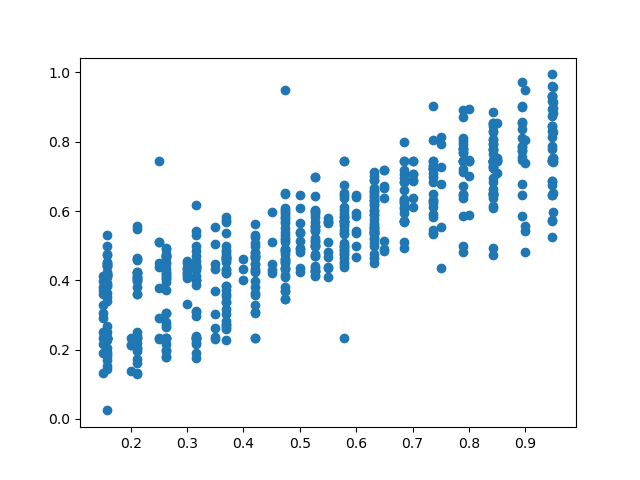

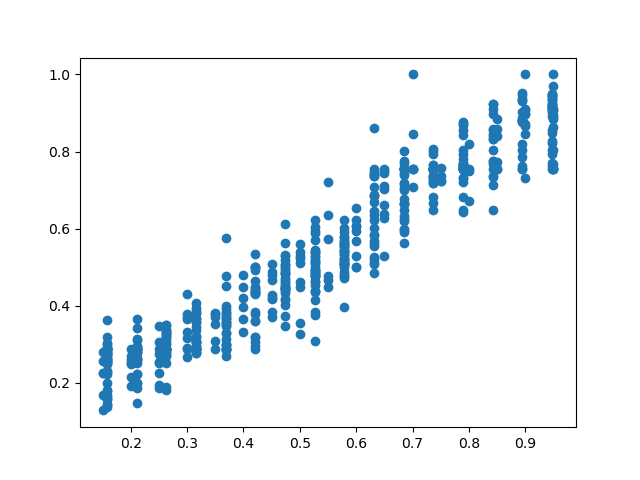

In [26]:
t_weights, t_amps, t_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, 2, targets, degree=1)
# nt_weights, nt_amps, nt_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, 2, nontargets, degree=2)

In [ ]:
target_combos_flat = cartesian_product_pp(t_weights)
target_combos = np.reshape(target_combos_flat, (len(target_combos_flat), len(targets), 
                                                int(target_combos_flat.shape[-1] / len(targets))))

nt_weights = np.vstack(nt_weights)

In [ ]:
target_combos

In [ ]:
T_t = cp.Variable(1)
T_n = cp.Variable(1)
x = cp.Variable(target_combos.shape[-1] - 1)
I_max = 1.78125

constraints = [
    -target_combos[0, :, 0] - target_combos[0, :, 1:] @ x  <= T_t,
    nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
    x[0] <= I_max,
    -I_max <= x[0],
    x[1] <= I_max,
    -I_max <= x[1], 
    x[2] <= I_max,
    -I_max <= x[2],
    x[3] == cp.multiply(x[0], x[0]),
    x[4] <= I_max**2,
    -I_max**2 <= x[4],
    x[5] <= I_max**2,
    -I_max**2 <= x[5],
    x[6] <= I_max**2,
    0 <= x[6],
    x[7] <= I_max**2,
    -I_max**2 <= x[7],
    x[8] <= I_max**2,
    0 <= x[8]
]

objective_function = cp.exp(T_n) + cp.exp(T_t)

objective = cp.Minimize(objective_function)
prob = cp.Problem(objective, constraints)
opt_val  = prob.solve()

print(f"Optimal value {opt_val}")

print(f"optimal p_t {compute_pt(T_t.value)[0]}")
print(f"optimal p_n {compute_pn(T_n.value)[0]}")
print(f"optimal T_t {T_t.value[0]}")
print(f"optimal T_n {T_n.value[0]}")
print(x.value)

In [ ]:
def cartesian_product_pp(arrays, out=None):
    la = len(arrays)
    h, w = zip(*map(op.attrgetter('shape'), arrays))
    w = np.fromiter(it.chain([0], w), int, la+ 1)
    W = w.cumsum()
    h = *h, W[la]
    dtype = np.result_type(*arrays)
    arr = np.empty(h, dtype=dtype)
    arrs = *it.accumulate(it.chain((arr,), it.repeat(0, la-1)), np.ndarray.__getitem__),
    idx = slice(None), *it.repeat(None, la-1)
    for i in range(la-1, 0, -1):
        arrs[i][..., W[i]:W[i+1]] = arrays[i][idx[:la-i]]
        arrs[i-1][1:] = arrs[i]
    arr[..., W[0]:W[1]] = arrays[0][idx]
    return arr.reshape(-1, W[la])

In [ ]:
def compute_pt(T):
    return 1/(np.exp(T)+1)

def compute_pn(T):
    return np.exp(T)/(np.exp(T)+1)

In [ ]:
def computeSelecVec(target_combos, nt_weights, I_max=1.78125, verbose=False):
    selec_vals = np.zeros(len(target_combos))
    x_vals = np.zeros((len(target_combos), 3))
    for i in range(len(target_combos)):
        if verbose:
            print(i)
        T_t = cp.Variable(1)
        T_n = cp.Variable(1)
        x = cp.Variable(3)

        constraints = [
            -target_combos[i, :, 0] - target_combos[i, :, 1:] @ x  <= T_t,
            nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
            x[0] <= I_max,
            -I_max <= x[0],
            x[1] <= I_max,
            -I_max <= x[1], 
            x[2] <= I_max,
            -I_max <= x[2],  
        ]

        objective_function = cp.exp(T_n) + cp.exp(T_t)

        objective = cp.Minimize(objective_function)
        prob = cp.Problem(objective, constraints)
        opt_val  = prob.solve()
        if opt_val == np.inf:
            continue

        if verbose:
            print(f"Optimal value {opt_val}")

            print(f"optimal p_t {compute_pt(T_t.value)[0]}")
            print(f"optimal p_n {compute_pn(T_n.value)[0]}")
            print(f"optimal T_t {T_t.value[0]}")
            print(f"optimal T_n {T_n.value[0]}")
            print(x.value)

        selec_vals[i] = compute_pt(T_t.value)[0] * (1 - compute_pn(T_n.value)[0])
        x_vals[i] = x.value
        
    return selec_vals, x_vals

In [ ]:
p = 1
all_cells = np.array([124, 130], dtype=int)

In [ ]:
all_targets, all_nontargets = all_combos(all_cells)

In [ ]:
selec_comparison = []

In [ ]:
Imax = 1.78125
for m in range(len(all_targets)):
    m = 0
    print(m)
    targets = all_targets[m]
    nontargets = all_nontargets[m]

    classification = classifySelectivity(targets, nontargets)
    print(targets, nontargets, classification)
    
    best_1elec = get1elecSelectivity(dataset, electrical_path, gsort_path_1elec, estim_1elec, 
                                     wnoise, p, targets, nontargets, spont_limit=0.25, noise_limit=0.15, show_plots=True)
    
    print(best_1elec)
    
    t_weights, t_amps, t_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, p,
                                                     targets, downsample=False, downsample_trials=10, 
                                                     downsample_factor=2, load_from_mat=True, R2_thr=0.1, 
                                                     min_points_per_cluster=30, show_plots=True, verbose=True)
    nt_weights, nt_amps, nt_probs = fitMultielecSurface(electrical_path, gsort_path, dataset, estim, wnoise, p,
                                                        nontargets, downsample=False, downsample_trials=10, 
                                                        downsample_factor=2, load_from_mat=True, R2_thr=0.1, 
                                                        min_points_per_cluster=30, show_plots=True, verbose=True)
    
    target_combos_flat = cartesian_product_pp(t_weights)
    target_combos = np.reshape(target_combos_flat, (len(target_combos_flat), len(targets), 
                                                int(target_combos_flat.shape[-1] / len(targets))))
    
    nt_weights = np.vstack((nt_weights))

    selec_vals, x_vals = computeSelecVec(target_combos, nt_weights, I_max=Imax, verbose=True)
    print(selec_vals, x_vals)
    selec_vec = x_vals[np.argsort(selec_vals)[-1]]
    print(selec_vec)
    best_multielec = np.amax(selec_vals)
    print(best_multielec)
    
    selec_comparison.append((best_1elec, best_multielec, classification))
    
    multi_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    for i in range(len(nt_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$ = ' + str(multi_elecs[0]))
        plt.ylabel(r'$I_2$ = ' + str(multi_elecs[1]))
        plt.xlim(-Imax, Imax)
        plt.ylim(-Imax, Imax)
        ax.set_zlim(-Imax, Imax)
        ax.set_zlabel(r'$I_3$ = ' + str(multi_elecs[2]))

        scat = ax.scatter(nt_amps[i][:, 0], 
                    nt_amps[i][:, 1],
                    nt_amps[i][:, 2], marker='o', s=20, c=nt_probs[i], alpha=0.8)

        ax.scatter(x_vals[:, 0], x_vals[:, 1], x_vals[:, 2], c='tab:red', marker='*', s=200)

        clb = plt.colorbar(scat)
        plt.show()
        
    for i in range(len(t_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$ = ' + str(multi_elecs[0]))
        plt.ylabel(r'$I_2$ = ' + str(multi_elecs[1]))
        plt.xlim(-Imax, Imax)
        plt.ylim(-Imax, Imax)
        ax.set_zlim(-Imax, Imax)
        ax.set_zlabel(r'$I_3$ = ' + str(multi_elecs[2]))

        scat = ax.scatter(t_amps[i][:, 0], 
                    t_amps[i][:, 1],
                    t_amps[i][:, 2], marker='o', s=20, c=t_probs[i], alpha=0.8)

        ax.scatter(x_vals[:, 0], x_vals[:, 1], x_vals[:, 2], c='tab:red', marker='*', s=200)

        clb = plt.colorbar(scat)
        plt.show()

    break

In [ ]:
selec_vals

In [ ]:
selec_comparison

In [ ]:
plt.figure()
for i in range(len(selec_comparison)):
    if selec_comparison[i][2] == 'ON/OFF':
        color = 'tab:blue'
    if selec_comparison[i][2] == 'ON/ON':
        color = 'tab:red'
    if selec_comparison[i][2] == 'OFF/OFF':
        color = 'tab:orange'
    if selec_comparison[i][2] == 'mixed':
        color = 'tab:purple'
    plt.scatter(np.array(selec_comparison)[i, 0].astype(float), 
                np.array(selec_comparison)[i, 1].astype(float), alpha=0.5, c=color)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--', c='k')
plt.xlabel('Single-electrode selectivity')
plt.ylabel('Triplet selectivity')
leg = plt.legend(['OFF/OFF'])#, 'ON/ON', 'OFF/OFF', 'mixed'])
leg.legendHandles[0].set_color('tab:orange')
# leg.legendHandles[1].set_color('tab:red')
# leg.legendHandles[2].set_color('tab:orange')
# leg.legendHandles[3].set_color('tab:purple')